## Time series forecasting with Random Forest (Regression), in the context of WISDom project

### Testing SVR approach in Random Forest algorithm

#### Data:
    1. Flow Rate Data from a sensor in a Water Sypply System located in Barreiro
    2. Holidays since 1970 to 2029 (+ 3 regional holidays of 2018)

## Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#global variables
D=10 #how many lagged values to consider
min_date_train='2018-04-01'
max_date_train='2018-05-31'
min_date_predict='2018-06-01'
max_date_predict='2018-06-30'

## Loading data

In [3]:
header = ["date","time","flow","anomaly"]
df = pd.read_csv('barreiro_ano.csv', sep=';', names=header)
df

,date,time,flow,anomaly
0,01/01/2018,00:07:30,18.333067,0
1,01/01/2018,00:22:30,18.333067,0
2,01/01/2018,00:37:30,19.784872,0
3,01/01/2018,00:52:30,22.294744,0
4,01/01/2018,01:07:30,27.229756,0
...,...,...,...,...
35035,31/12/2018,22:52:30,24.792000,0
35036,31/12/2018,23:07:30,23.029933,0
35037,31/12/2018,23:22:30,20.415628,0
35038,31/12/2018,23:37:30,22.019056,0


In [4]:
#convert column to date time
df['date'] = pd.to_datetime(df['date'])

In [5]:
# to extract all unique values (time) present in dataframe
time_unique_val=df.time.unique()

In [6]:
# in order to accept time series with different periods per day
periods_per_day=len(time_unique_val)
periods_per_day

96

In [7]:
# to create an array with all these indexes
time_unique_ind=np.arange(periods_per_day)

In [8]:
#in order to have a mapping between the time of day and its index
time_unique=pd.DataFrame({'time':time_unique_val, 'time_unique_ind':time_unique_ind})
time_unique

,time,time_unique_ind
0,00:07:30,0
1,00:22:30,1
2,00:37:30,2
3,00:52:30,3
4,01:07:30,4
...,...,...
91,22:52:30,91
92,23:07:30,92
93,23:22:30,93
94,23:37:30,94


In [9]:
#creates a column with the time index
df['time_ind'] = df['time'].map(time_unique.set_index('time')['time_unique_ind'])

In [10]:
#extra column indicating day of week
#0: mon, 1:tue, ..., 5:sat, 6:sun
df['dayofweek'] = pd.to_datetime(df['date'],dayfirst=True)
df['dayofweek'] = df['dayofweek'].dt.dayofweek

In [11]:
holidays = pd.read_csv('holidays2018.csv',sep=';')
holidays['date'] = pd.to_datetime(holidays['date'])

In [12]:
# if day is a holiday, then dayofweek is -1
df.loc[df.date.isin(holidays.date), 'dayofweek'] = -1

## Lags of time series

### n previous readings

In [13]:
# in order to construct a new dataframe with D lagged values
df_lagged = df.copy()
number_lags = D # this is D (a global variable - check top of notebook)

for i in range(1, number_lags+1):
    shifted = df['flow'].shift(i)
    df_lagged = pd.concat((df_lagged, shifted), axis=1)

In [14]:
# just to label the columns of the resulting dataframe
lagged_cols=["n-"+ str(x) for x in range(1,number_lags+1)]
colnames= ["date","time","flow","anomaly", "time_ind","dayofweek"]+lagged_cols
df_lagged.columns=colnames

In [15]:
# in order to drop the rows corresponding do the first day
#to get rid of the NaN values
df_lagged =  df_lagged.iloc[periods_per_day:]

In [16]:
#df_weekdays: contains data related to weekdays 
#df_sat: contains data related to saturdays
#df_sun: contains data related to sundays and holidays
df_weekdays = df_lagged[(df_lagged['dayofweek']>=0) & (df_lagged['dayofweek']<=4)]
df_sat = df_lagged[df_lagged['dayofweek']==5]
df_sun = df_lagged[(df_lagged['dayofweek']==-1) | (df_lagged['dayofweek']==6)]

In [17]:
#get data to train a particular period (first of the day, eg)
'''
to create a dataframe that can be used to train a model
we should choose a range of dates (min_date, max_date)
a typeofdate ('weekdays', 'saturdays', 'sundays' (this one includes holidays))
and a period of the day (time_ind that can range from 0 to periods_per_day)
'''
def create_data_for_model(min_date, max_date, typeofday, time_ind):
    if typeofday=='weekdays':
        sel_data=df_weekdays[(df_weekdays.date>=min_date) & (df_weekdays.date<=max_date)]
    elif typeofday=='saturdays':
        sel_data=df_sat[(df_sat.date>=min_date) & (df_sat.date<=max_date)]
    else:
        sel_data=df_sun[(df_sun.date>=min_date) & (df_sun.date<=max_date)]
    sel_data=sel_data[sel_data['time_ind']==time_ind]
    return sel_data

In [18]:
#an example, just to test
data=create_data_for_model('2018-01-01', '2018-01-30', 'weekdays', 0)
#data

In [19]:
y=data['flow'].copy()
X=data.iloc[:,6:] #contains only the D previous values

## Random Forest model

In [21]:
"""
data: dataframe containing data for a specific type of day and 
for a specific time_ind
"""
def rf_model(X,y):
    # 70% train, 30% test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    # in order to fetch the parameter values
    rf_model = RandomForestRegressor(n_estimators=100)
    rf_model.fit(X_train, y_train)
    return rf_model

In [22]:
# creates a model for each period for weekdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_weekdays(min_date, max_date):
    regressors_weekdays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        regressors_weekdays.append(rf_model(X,y))
    return regressors_weekdays

In [23]:
# creates a model for each period for saturdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_saturdays(min_date, max_date):
    regressors_saturdays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        regressors_saturdays.append(rf_model(X,y))
    return regressors_saturdays

In [24]:
# creates a model for each period for sundays and holidays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_sundays(min_date, max_date):
    regressors_sundays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        regressors_sundays.append(rf_model(X,y))
    return regressors_sundays

In [25]:
def predict_flow(df):
    predictions=[]
    for i in range(len(df)):
        if ((df.iloc[i,5]>=0) and (df.iloc[i,5] <=4)):
            model=regressors_weekdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        elif (df.iloc[i,5]==5): # i.e. saturdays
            model=regressors_saturdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        else: #i.e., sundays and holidays
            model=regressors_sundays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
      
    return predictions

In [26]:
# for testing, we will use 2018-01-01 to 2018-01-31 for
# constructing regressors
regressors_weekdays=creates_regressors_weekdays(min_date_train, max_date_train)
regressors_saturdays=creates_regressors_saturdays(min_date_train, max_date_train)
regressors_sundays=creates_regressors_weekdays(min_date_train, max_date_train)

In [27]:
df2predict=df_lagged[(df_lagged.date>=min_date_predict) & (df_lagged.date<=max_date_predict)]

In [28]:
predictions=predict_flow(df2predict)

In [29]:
real=df2predict['flow']
real_1d=real[0:periods_per_day] # to look at 1 day

In [30]:
predictions_1d=predictions[0:periods_per_day]

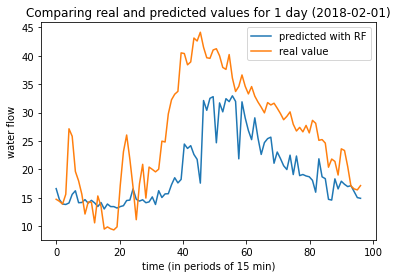

RBF model Test MSE: 77.040


In [31]:
x = np.linspace(0,len(predictions_1d),len(predictions_1d)) 
plt.plot(x,predictions_1d,label='predicted with RF')
plt.plot(x,real_1d, label='real value')
plt.xlabel('time (in periods of 15 min)')
plt.ylabel('water flow')
plt.title("Comparing real and predicted values for 1 day (2018-02-01)")
plt.legend()
plt.show()

# evaluation metrics
error = mean_squared_error(real_1d, predictions_1d)
result= print('RBF model Test MSE: %.3f' % error)
result

In [32]:
real_7d=real[0:periods_per_day*7] # to look at 7 day
predictions_7d=predictions[0:periods_per_day*7]

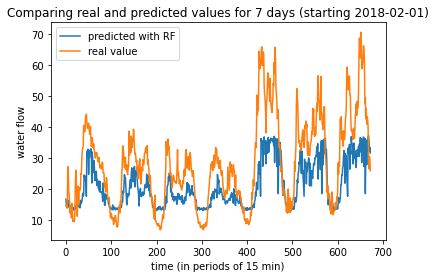

RBF model Test MSE: 139.577


In [33]:
x = np.linspace(0,len(predictions_7d),len(predictions_7d)) 
plt.plot(x,predictions_7d,label='predicted with RF')
plt.plot(x,real_7d, label='real value')
plt.xlabel('time (in periods of 15 min)')
plt.ylabel('water flow')
plt.title("Comparing real and predicted values for 7 days (starting 2018-02-01)")
plt.legend()
plt.show()

# evaluation metrics
error = mean_squared_error(real_7d, predictions_7d)
result= print('RBF model Test MSE: %.3f' % error)
result